In [1]:
import random
import numpy as np
import gym
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython.display import display
from time import sleep

## Create the environment

In [2]:
env = gym.make('Taxi-v3')

print('There are total {} states'.format(env.observation_space.n))
print('There are total {} actions'.format(env.action_space.n))

env.render()

There are total 500 states
There are total 6 actions
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Create empty Q-table

In [3]:
# state space, action space
nS, nA = env.observation_space.n, env.action_space.n
# create empty Q-table
Q = np.zeros((nS, nA), dtype=np.float64)
print(Q)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


## Set Hyperparameters

In [4]:
## in each episode, max step is 100
max_steps = 100
## we will run total 10,000 episodes
n_episodes = 100000

gamma = 1.0

def decay_schedule(max_value, min_value, decay_ratio, steps, log_start=-2, log_base=10):
    decay_steps = int(steps * decay_ratio)
    rem_steps = steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (max_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

# exploration rate, epsilon
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay_ratio = 0.9
epsilons = decay_schedule(max_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

# learning rate, alphas:
max_alpha = 0.7
min_alpha = 0.1
alpha_decay_ratio = 0.9
alphas = decay_schedule(max_alpha, min_alpha, alpha_decay_ratio, n_episodes)

## Learn until converge

In [5]:
# q-table for SARSA
sarsa_Q = np.zeros((nS, nA))

# record episode rewards
sarsa_epi_rew = []

# play n_episodes
for e in tqdm(range(n_episodes), leave=False):
    # Reset the environment
    state = env.reset()
    done = False
    
    # take initial action using epsilon-greedy        
    if random.random() < epsilons[e]:
        action = random.randrange(env.action_space.n)
    else:
        action = np.argmax(sarsa_Q[state])

    for step in range(max_steps):
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        next_state, reward, done, _ = env.step(action)

        # sarsa_Q[next_state,:] all the actions we can take from new state
        # sample next_action using epsilon-greedy        
        if random.random() < epsilons[e]:
            next_action = random.randrange(env.action_space.n)
        else:
            next_action = np.argmax(sarsa_Q[state])
            
        sarsa_Q[state, action] = sarsa_Q[state, action] \
                    + alphas[e] * (reward + gamma * sarsa_Q[next_state, next_action] - sarsa_Q[state, action])

        # state transition
        state = next_state
        action = next_action

        # If done: finish episode
        if done: 
            break
        
    # append episode reward for performance visualization
    sarsa_epi_rew.append(reward)
    

print('Learned Q-table:')
print(sarsa_Q)
print('Learned Value of states:')
print(np.sum(sarsa_Q, axis=1))

Learned Q-table:
[[  0.           0.           0.           0.           0.
    0.        ]
 [-16.20814344  -6.01796829 -19.03483922  -6.05017366  -5.03987121
  -16.26969085]
 [ -7.43462192   2.70699967 -11.11121304   2.81023993   3.74584217
   -7.83759453]
 ...
 [  8.73018976  14.51121067  12.32202925   5.60328529   0.21032561
   -0.28794217]
 [-22.63252813   0.69822428 -28.32715019 -15.97647482 -32.31346083
  -35.16940122]
 [ 16.79094639  15.0432322   15.52497741  17.97523591   7.86438026
    7.42385318]]
Learned Value of states:
[    0.           -68.62068667   -17.12034772   -89.67614719
  -779.63783853     0.          -908.53060049  -595.85043602
  -166.02535649  -244.28066844     0.          -259.39031292
  -961.13558888  -588.00540012 -1061.22917907     0.
    81.74937393    -3.43631122    45.58585872   -26.26089709
     0.           -90.12399557   -24.31882196  -103.31025825
  -607.51026787     0.          -689.76833993  -677.5874814
  -195.28586655  -350.21524595     0.       

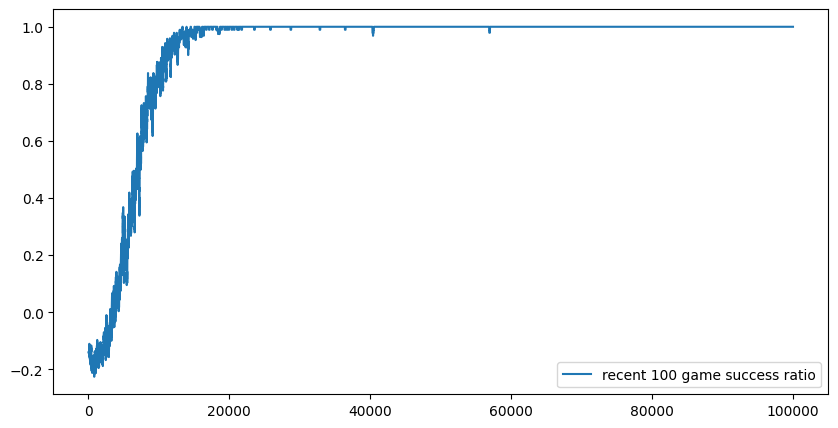

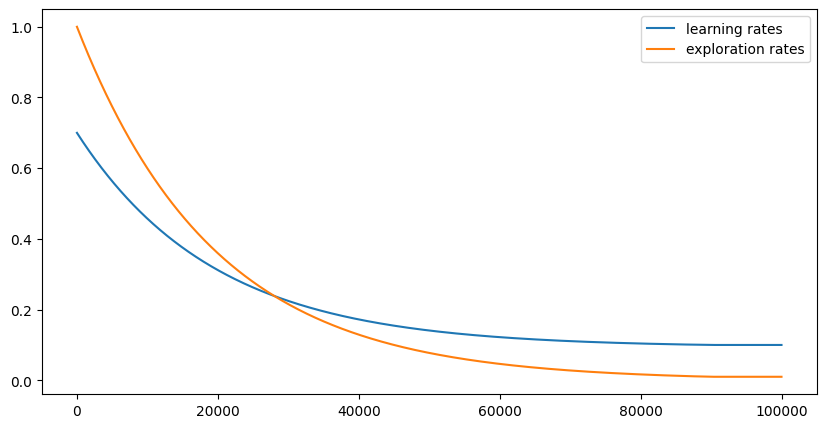

In [6]:
# success rate of recent [window_size] games
window_size = 100
plt.figure(figsize=(10, 5))
plt.plot([(np.mean(sarsa_epi_rew[:window_size])/20) for i in range(window_size)] + [np.mean(sarsa_epi_rew[i - window_size:i])/20 for i in range(window_size, len(sarsa_epi_rew))], label='recent {} game success ratio'.format(window_size))
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(alphas, label='learning rates')
plt.plot(epsilons, label='exploration rates')
plt.legend()
plt.show()
plt.close()

## Play with Q-table

In [8]:
for episode in range(5):
    state = env.reset()
    done = False
    frames = []

    for step in range(max_steps):
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(sarsa_Q[state])
      
        next_state, reward, done, info = env.step(action)
    
        frames.append({
            'frame' : env.render(mode='ansi'),
            'state' : next_state,
            'action' : action,
            'reward' : reward
        })
    
        if done:
            break
    
        state = next_state
    
    for step, frame in enumerate(frames):
        clear_output(wait=True)
        keys = list(frame.keys())
        print(frame['frame'])
        print(f"step : {step + 1}")
        for key in keys[1:]:
            print(f"{key}: {frame[key]}")
        sleep(1)
    sleep(3)
    
env.close()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

step : 14
state: 475
action: 5
reward: 20
